In [1]:
from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm
#pd.set_option('display.max_colwidth', 200)

In [2]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [3]:
import PyPDF2

import warnings
warnings.filterwarnings("ignore")

filepath = "GS.07.50734_Technical assessment of spoolable fibre.pdf"
pdfFileObj = open(filepath, 'rb') 
pdfreader = PyPDF2.PdfFileReader(pdfFileObj) 
count = pdfreader.numPages

text = ''
#text1 = []
for j in range(count):
    page = pdfreader.getPage(j)
    pp = page.extractText()
    text = text + pp
    #text1 .append(pp)

#print(text)

In [4]:
text2 = nlp(text)
for word in text2.ents:
    print(word.text, word.label_)

1030 CARDINAL
Amsterdam GPE
NetherlandsTel ORG
99Technical CARDINAL
SEPCO - Transportation ORG
USA GPE
Texas GPE
Wyoming GPE
Washington State ORG
SEPCO - Transportation ORG
USA GPE
West Texas GPE
Wyoming GPE
Washington State ORG
Janssen PERSON
P.J.M. van Loon PERSON
K.M. Orzessek PERSON
J.B.W. van Zummeren PERSON
Shell Global Solutions International B.V. ORG
The Hague GPE
2007 DATE
Shell Global Solutions ORG
the Shell Group ORG
1 CARDINAL
99 CARDINAL
Shell Exploration and Production Company ORG
SEPCO ORG
International B.V. ORG
Shell ORG
USA GPE
West Texas GPE
Wyoming GPE
Washington GPE
DEP 31.40.10.20-Gen PRODUCT
Fiberspar GPE
Shell Global Solutions US Inc. ORG
Fiberspar GPE
SEPCO ORG
DEP 31.40.10.20-Gen PRODUCT
Fiberspar GPE
SEPCO ORG
Shell ORG
DEP 31.40.10.20-Gen ORG
1500 CARDINAL
103 CARDINAL
60 CARDINAL
140 CARDINAL
up to 4.5 CARDINAL
Amsterdam GPE
March 2007 DATE
2 CARDINAL
99 CARDINAL
1 1 CARDINAL
4 CARDINAL
3 CARDINAL
4 CARDINAL
4 CARDINAL
4 5 DATE
4 CARDINAL
4 CARDINAL
5.2 Conc

1.5 CARDINAL
1.5 CARDINAL
Fiberspar GPE
99 CARDINAL
40Manual CARDINAL
021606 CARDINAL
LinePipe LLC                                         WORK_OF_ART
15 CARDINAL
19 CARDINAL
20% PERCENT
50% PERCENT
Pay PERSON
20% PERCENT
up to 200 CARDINAL
psi ORG
about 30 

minutes TIME
up to about 5000 CARDINAL
2 hours TIME
4 hours TIME
24 

hours TIME
5 CARDINAL
zero CARDINAL
Particular ORG
H. Static Discharge PERSON
Fiberspar LinePipe WORK_OF_ART
99 CARDINAL
41Manual CARDINAL
021606 CARDINAL
2006 DATE
LinePipe LLC                                        Page WORK_OF_ART
16 CARDINAL
19 CARDINAL
Fiberspar LinePipe FAC
Fiberspar GPE
LinePipe ORG
OD ORG
LinePipe ORG
LinePipe ORG
Fiberspar LinePipe FAC
CAR ORG
99 CARDINAL
42Manual CARDINAL
021606 CARDINAL
2006 DATE
LinePipe LLC                                         WORK_OF_ART
17 CARDINAL
19 CARDINAL
APPENDIX GPE
SPECIFICATIONS ORG
99 CARDINAL
43Manual CARDINAL
021606 CARDINAL
2006 DATE
LinePipe LLC                                        Page WORK_OF_

In [6]:
from spacy import displacy

#displacy.render(text2, style = 'dep', jupyter = True)
displacy.render(text2, style = 'ent', jupyter = True)

In [8]:
#spacy.explain('ORG')

In [9]:
doc  = nlp(text)
sentences = list(doc.sents)

number = str(len(sentences))
print(number)


1799


In [10]:
import pandas as pd

df = pd.DataFrame(columns = ['Sentence'])
for i, sentence in enumerate(sentences):
#    print(i, '-' + str(sentence))
    j = str(sentence)
    df = df.append({'Sentence':j}, ignore_index = True)
    
print(df.head(10))

                                            Sentence
0  For further information, contact Shell Global ...
1                                   P.O. Box 38 000,
2                                          1030 BN  
3                                      Amsterdam\n\n
4                                The NetherlandsTel.
5                                                :\n
6                                  +31(0)206303355\n
7                             Fax: +31(0)206302989\n
8                                  Email: materials-
9                        inspection@shell.comWeb: \n


In [13]:
def get_entities(sent):
    ent1 = ""
    ent2 = ""
    prv_tok_dep = "" 
    prv_tok_text = "" 
    prefix = ""
    modifier = ""
    for tok in nlp(sent):
        if tok.dep_ != "punct":
            if tok.dep_ == "compound":
                prefix = tok.text
            if prv_tok_dep == "compound":
                prefix = prv_tok_text + " "+ tok.text
      
        if tok.dep_.endswith("mod") == True:
            modifier = tok.text
        if prv_tok_dep == "compound":
            modifier = prv_tok_text + " " + tok.text
      
        if tok.dep_.find("subj") == True:
            ent1 = modifier + " " + prefix + " " + tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""    
        
        if tok.dep_.find("obj") == True:
            ent2 = modifier + " " + prefix + " " + tok.text
        
    prv_tok_dep = tok.dep_
    prv_tok_text = tok.text

    return [ent1.strip(), ent2.strip()]

In [14]:
#Example

get_entities('The film had 200 patents.')

['film', '200  patents']

In [15]:
entity_pairs = []

for i in tqdm(df["Sentence"]):
    entity_pairs.append(get_entities(i))

100%|█████████████████████████████████████████████████████████████████████████████| 1799/1799 [00:09<00:00, 181.37it/s]


In [17]:
#subject-object pairs

entity_pairs[10:20]

[['', ''],
 ['EAR ECCN assessment', 'wet SEPCO gas'],
 ['Technical West assessment', 'sour F.A.H. Janssen'],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['', ''],
 ['recipient', 'copyright owner']]

In [19]:
def get_relation(sent):
    doc = nlp(sent)
    matcher = Matcher(nlp.vocab)
    pattern = [{'DEP':'ROOT'}, {'DEP':'prep','OP':"?"}, {'DEP':'agent','OP':"?"}, {'POS':'ADJ','OP':"?"}] 
    matcher.add("matching_1", None, pattern) 
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
    return(span.text)

In [20]:
#Predicates

relations = [get_relation(i) for i in tqdm(df['Sentence'])]


 24%|███████████████████                                                            | 435/1799 [00:07<00:25, 53.42it/s]


 52%|█████████████████████████████████████████                                      | 934/1799 [00:14<00:14, 59.36it/s]


 78%|████████████████████████████████████████████████████████████▌                 | 1396/1799 [00:22<00:05, 72.14it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1799/1799 [00:28<00:00, 64.05it/s]


In [29]:
pd.Series(relations).value_counts()[:10]

*              53
is             42
GS.07.50734    28
EAR            25
be             24
are            20
rev            19
used           17
LLC            15
1,000          14
dtype: int64

In [22]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})


In [48]:
kg_df.head(25)

,source,target,edge
0,,Materials International B.V.,Solutions at
1,,,Box
2,,,BN
3,,,Amsterdam
4,,,NetherlandsTel
5,,,:
6,,,+31(0)206303355
7,,,Fax
8,,,Email
9,,,inspection@shell.comWeb


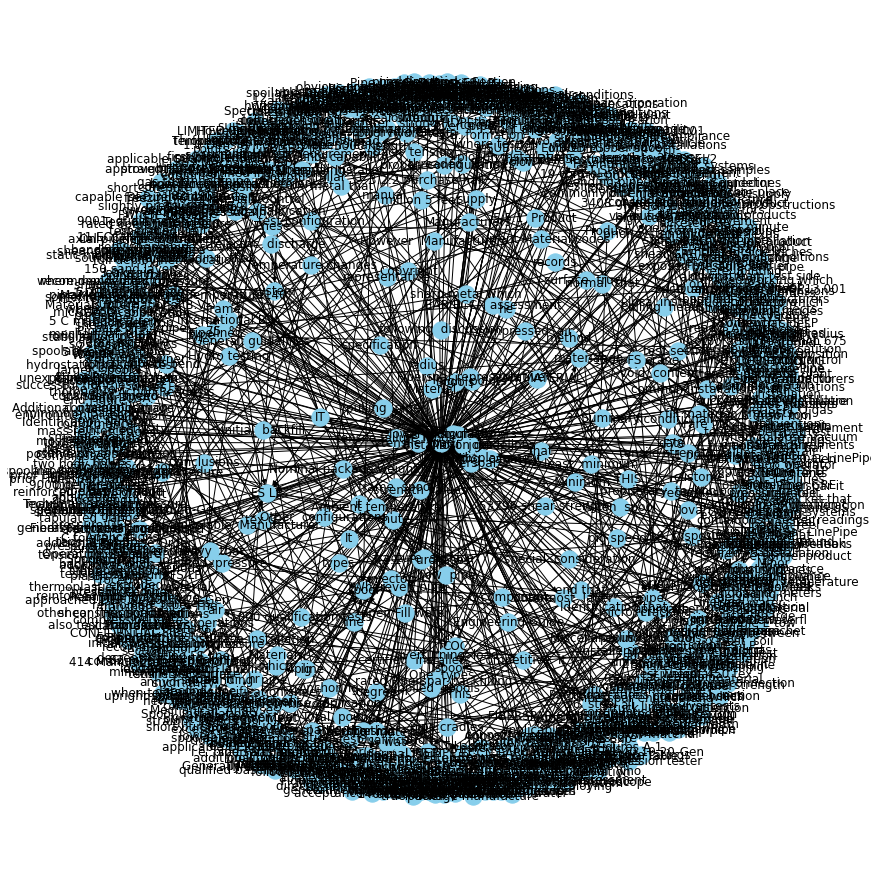

In [24]:
G = nx.from_pandas_edgelist(kg_df, 'source', 'target', edge_attr = True, create_using = nx.MultiDiGraph())

plt.figure(figsize = (10, 10))
pos = nx.spring_layout(G, k = 0.5) #k regulates distance between nodes
nx.draw(G, with_labels = True, node_color = 'skyblue', edge_cmap = plt.cm.Blues, pos = pos)
plt.show()

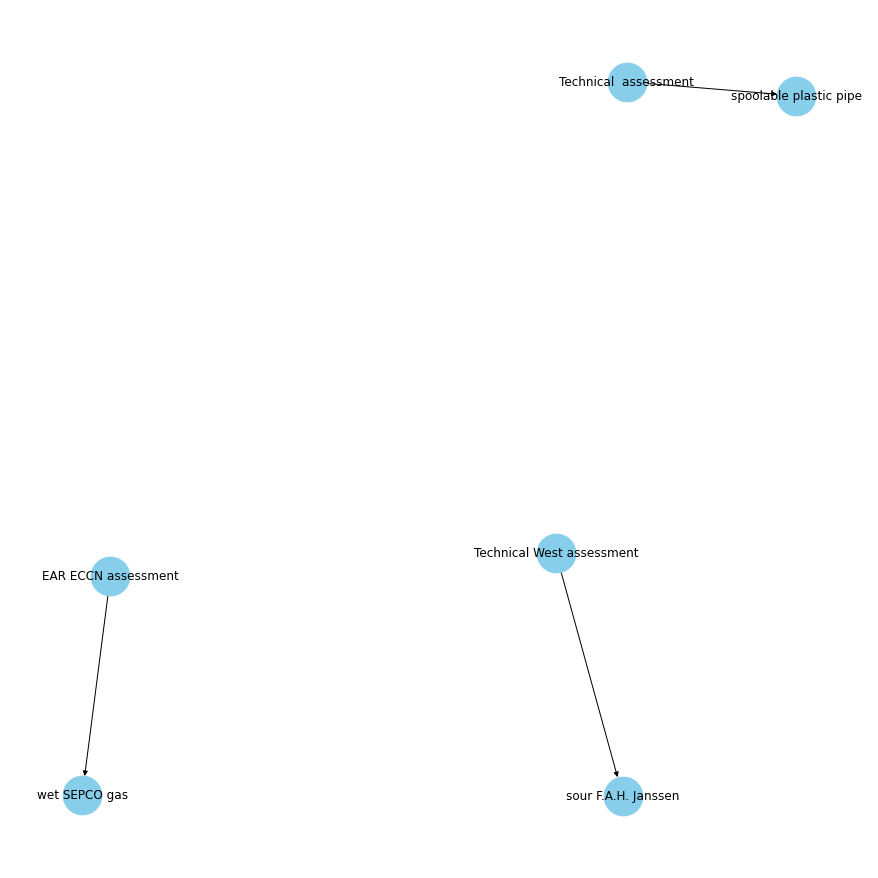

In [47]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == "reinforced"], 'source', 'target', edge_attr = True, create_using = nx.MultiDiGraph())

plt.figure(figsize = (12, 12))
pos = nx.spring_layout(G, k = 0.5) #k regulates distance between nodes
nx.draw(G, with_labels = True, node_color = 'skyblue', node_size = 1500, edge_cmap = plt.cm.Blues, pos = pos)
plt.show()

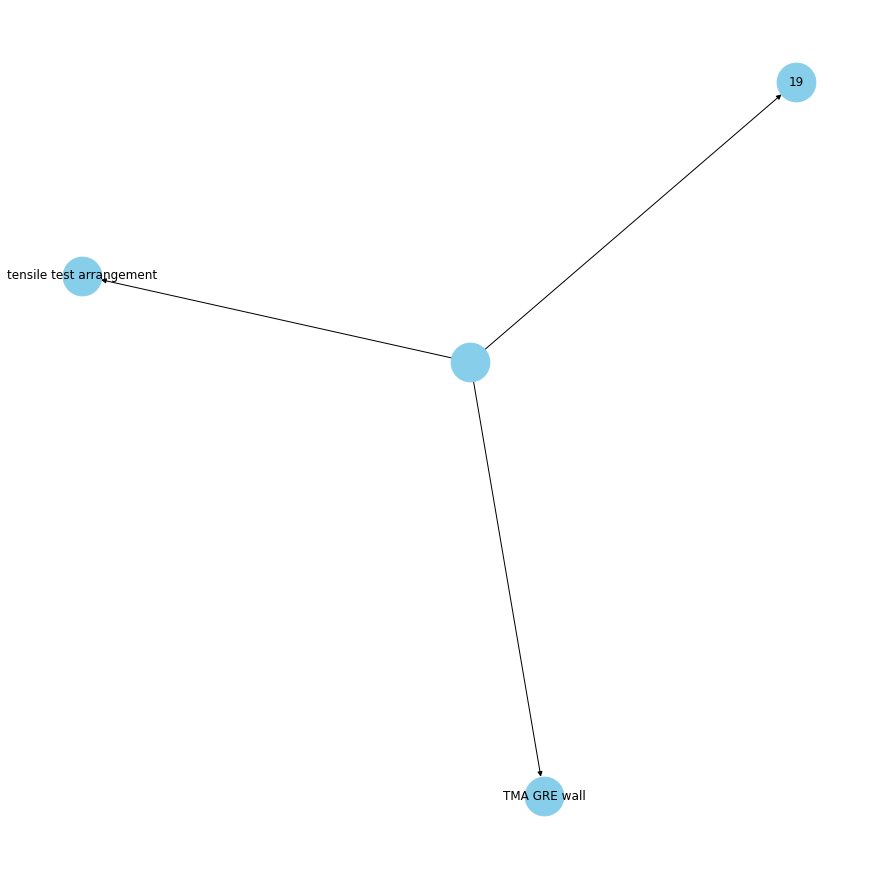

In [49]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == "GS.07.50734"], 'source', 'target', edge_attr = True, create_using = nx.MultiDiGraph())

plt.figure(figsize = (12, 12))
pos = nx.spring_layout(G, k = 0.5) #k regulates distance between nodes
nx.draw(G, with_labels = True, node_color = 'skyblue', node_size = 1500, edge_cmap = plt.cm.Blues, pos = pos)
plt.show()